In [8]:
from dataGen import Gen
from vae import VariationalAutoencoder

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.distributions
# from torchsummary import summary
import tqdm as notebook_tqdm

import numpy as np
import matplotlib.pyplot as plt

In [186]:
class slidingWindow(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        if self.data.shape[1] - index >= self.window:            
            x = self.data[:,index:index+self.window]
        
            return x

    def __len__(self):
        return self.data.shape[1] - self.window

In [176]:
class shortEncoder(nn.Module):
    def __init__(self, n_channels, L, latent_dims):
        super(shortEncoder, self).__init__()        
        
         ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv1d(n_channels, n_channels*2, kernel_size=2, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm1d(n_channels*2),
            
            nn.Conv1d(n_channels*2, n_channels*4, kernel_size=2, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm1d(n_channels*4),   
            
            nn.Conv1d(n_channels*4, n_channels*8, kernel_size=2, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm1d(n_channels*8),
        )       
        
        ### Linear section: mean
        self.encoder_mu = nn.Sequential(
            nn.Linear(L//8 * n_channels*8, 100),
            nn.ReLU(True),
            nn.Linear(100, latent_dims)
        )
        
        self.encoder_var_log = nn.Sequential(
            nn.Linear(L//8 * n_channels*8, 100),
            nn.ReLU(True),
            nn.Linear(100, latent_dims)
        )
         

    def forward(self, x):
        ### CNN
        x = self.encoder_cnn(x) 
        x = x.view(x.size(0),-1)
        
        ### MLP
        mu = self.encoder_mu(x)  
        var_log = self.encoder_var_log(x)
        
        return mu, var_log

class Decoder(nn.Module):
    def __init__(self, n_channels, latent_dims):
        super(Decoder, self).__init__()        
        
         ### Linear section
        self.dec_lin = nn.Sequential(
            nn.Linear(latent_dims, 100),
            nn.ReLU(True),
            nn.Linear(100, n_channels)
        )      

    def forward(self, x):
        ### CNN
        x = self.dec_lin(x)  
        return x     

In [177]:
class vae(nn.Module):
    def __init__(self, n_channels, L, latent_dims):
        super(vae, self).__init__()
        
        self.encoder = shortEncoder(n_channels, L, latent_dims)
        self.decoder = Decoder(n_channels, latent_dims)
        
    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrization_trick(mu, logvar)
        return self.decoder(z), mu, logvar   

In [243]:
### Cost function
def criterion(recon_x, x, mu, logvar):
    ### reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
#     recon_loss = nn.MSELoss(recon_x, x, reduction='sum')

    ### KL divergence loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    ### total loss
    loss = recon_loss + kld_loss
    return loss

### Train function
def train(v, train_loader, criterion, optimizer, device, epoch):
    v.train()
    train_loss = 0
#     rec_bach = torch.tensor([])
#     for i in range(0, params["T"]-L):
    for batch_idx, data in enumerate(train_loader):
#         W = torch.tensor(serie.T[i:i+L]).float()
        
        data = data.to(device)
        optimizer.zero_grad()
        x_rec, mu, logvar = v(data)
#         rec_bach = torch.cat((rec_bach, x_rec), 0)
#     print(serie.T[:params["T"]-L].shape)
#     loss = criterion(rec_bach, serie.T[:params["T"]-L].squeeze(), mu, logvar)
        
#         recon_batch, mu, logvar = vae(W)
#         print(x_rec.shape)
#         print(data.shape)
        loss = criterion(x_rec, data[:,:,0], mu, logvar)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

### Test Function
def test(vae, test_loader, criterion, device):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = vae(data)
            
            ### sum up batch loss
            loss = criterion(recon_batch, data, mu, logvar)
            test_loss += loss.item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [279]:
# all parameters for generating the time series should be configured in this cell
time = 100
step = 0.2
val = 100
n_channels = 3
effects = {
    "Pulse": {
        "number":2,
        "max_gain":5        
        },
    "Trend": {
        "number":1,
        "max_slope":3
        },
    "Seasonality": {
        "number":0,
        "frequency_range":(10, 30),
        "amplitude_range":(10, 20),
        }
    }

### Init Model
latent_dims = 10
L = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'

v = vae(n_channels, L, latent_dims)
opt = optim.Adam(v.parameters())

{'T': 500, 'nchannels': 3, 'mu': array([ 5, 91, 71]), 'cov': array([[3.10757225, 0.        , 0.        ],
       [0.        , 2.08163971, 0.        ],
       [0.        , 0.        , 1.10913594]])}
{'Pulse': {'channel': [0, 1], 'index': [55, 39], 'scale': [-0.16868902375996164, 0.40685167302380165]}, 'Trend': {'channel': [2], 'index': [36], 'slope': [1]}, 'Seasonality': {'channel': [], 'frequency': [], 'amplitude': [], 'phaseshift': []}}


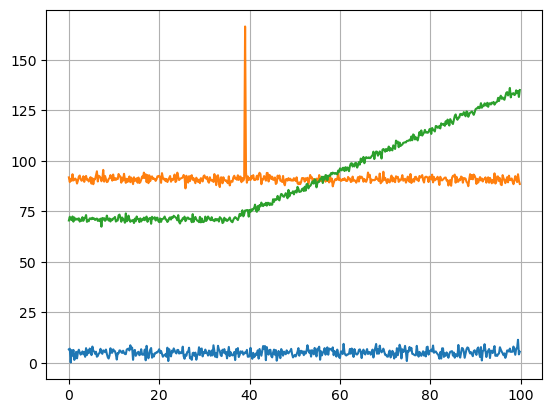

In [280]:
X = Gen(time, step, val, n_channels, effects)
serie, params, e_params = X.parameters()
print(params)
print(e_params)
X.show()

In [315]:
serie = torch.tensor(serie).float()
train_set = slidingWindow(serie, 30)
train_data = DataLoader(train_set,
#                         batch_sampler= slidingWindow(Dataset)
                        batch_size=2,
                        shuffle = False
                        )

/tmp/ipykernel_205/379980147.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  serie = torch.tensor(serie).float()


In [316]:
for epoch in range(1, 50):
    train(v, train_data, criterion, opt, device, epoch)

Train Epoch: 1 [0/470 (0%)]	Loss: 18.638214
Train Epoch: 1 [200/470 (43%)]	Loss: 16.225735
Train Epoch: 1 [400/470 (85%)]	Loss: 10.342966
====> Epoch: 1 Average loss: 14.6810
Train Epoch: 2 [0/470 (0%)]	Loss: 20.276550
Train Epoch: 2 [200/470 (43%)]	Loss: 10.790072
Train Epoch: 2 [400/470 (85%)]	Loss: 16.286144
====> Epoch: 2 Average loss: 12.4743
Train Epoch: 3 [0/470 (0%)]	Loss: 12.319946
Train Epoch: 3 [200/470 (43%)]	Loss: 9.956608
Train Epoch: 3 [400/470 (85%)]	Loss: 7.529825
====> Epoch: 3 Average loss: 13.0447
Train Epoch: 4 [0/470 (0%)]	Loss: 17.104263
Train Epoch: 4 [200/470 (43%)]	Loss: 8.540979
Train Epoch: 4 [400/470 (85%)]	Loss: 14.225659
====> Epoch: 4 Average loss: 14.4465
Train Epoch: 5 [0/470 (0%)]	Loss: 15.666748
Train Epoch: 5 [200/470 (43%)]	Loss: 5.242817
Train Epoch: 5 [400/470 (85%)]	Loss: 12.656364
====> Epoch: 5 Average loss: 13.7442
Train Epoch: 6 [0/470 (0%)]	Loss: 9.945406
Train Epoch: 6 [200/470 (43%)]	Loss: 7.676274
Train Epoch: 6 [400/470 (85%)]	Loss: 13.

Train Epoch: 47 [400/470 (85%)]	Loss: 17.382725
====> Epoch: 47 Average loss: 13.1811
Train Epoch: 48 [0/470 (0%)]	Loss: 10.246980
Train Epoch: 48 [200/470 (43%)]	Loss: 7.908318
Train Epoch: 48 [400/470 (85%)]	Loss: 16.411535
====> Epoch: 48 Average loss: 12.9331
Train Epoch: 49 [0/470 (0%)]	Loss: 12.166225
Train Epoch: 49 [200/470 (43%)]	Loss: 7.543941
Train Epoch: 49 [400/470 (85%)]	Loss: 19.712164
====> Epoch: 49 Average loss: 13.6328


(470, 3)


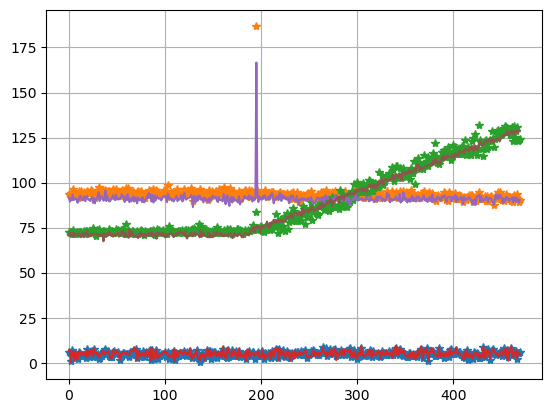

In [317]:
x_hat = np.array([])
z_hat = np.array([])
mu_hat = np.array([])
var_hat = np.array([])
# v.eval()
for i, data in enumerate(train_data):
    x_rec, mu, log = v(data)
    z = v.reparametrization_trick(mu, log)
#     print(z.shape)

    
#     loss = criterion(x_rec, W[0], mu, log)
    
    x_rec = x_rec.detach().numpy()
    z = z.detach().numpy()
    mu = mu.detach().numpy()
    log = log.detach().numpy()
#     print(x_rec.shape)
#     print(x_hat.shape)
    if len(x_hat) == 0:
        x_hat = x_rec
        z_hat = z
        mu_hat = mu
        var_hat = log
    else:
        x_hat= np.append(x_hat, x_rec, axis= 0)
        z_hat= np.append(z_hat, z, axis= 0)
        mu_hat= np.append(mu_hat, mu, axis= 0)
        var_hat= np.append(var_hat, log, axis= 0)
print(x_hat.shape)
plt.plot(x_hat, "*")
plt.plot(serie.T[:-L], "-")
plt.grid(True)

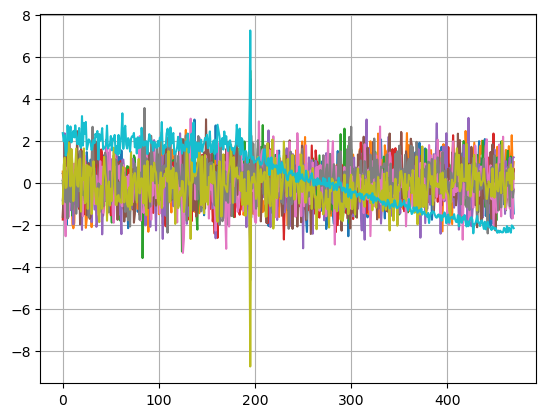

In [318]:
plt.plot(z_hat)
plt.grid(True)

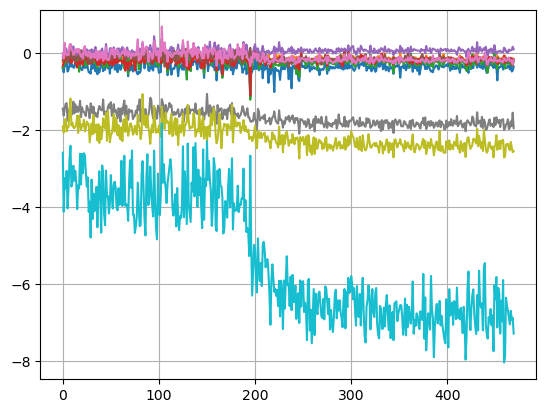

In [320]:
plt.plot(var_hat)
plt.grid(True)